In [ ]:
import json
import os
import random
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from nnsight import CONFIG, LanguageModel
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import (
    error_detection,
    get_query_charac_oi,
    get_query_object_oi,
    get_reversed_sent_diff_state_counterfacts,
    get_reversed_sentence_counterfacts,
)

current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(current_dir)))
from src import global_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

CONFIG.APP.REMOTE_LOGGING = False
CONFIG.set_default_api_key(global_utils.load_env_var("NDIF_KEY"))
os.environ["HF_TOKEN"] = global_utils.load_env_var("HF_WRITE")

%load_ext autoreload

/disk/u/nikhil/mind/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Characters, Objects, and States

In [2]:
all_characters = json.load(
    open(
        os.path.join(global_utils.DATA_DIR, "synthetic_entities", "characters.json"),
        "r",
    )
)
all_objects = json.load(
    open(
        os.path.join(global_utils.DATA_DIR, "synthetic_entities", "bottles.json"),
        "r",
    )
)
all_states = json.load(
    open(
        os.path.join(global_utils.DATA_DIR, "synthetic_entities", "drinks.json"),
        "r",
    )
)

print(f"#characters: {len(all_characters)}")
print(f"#objects: {len(all_objects)}")
print(f"#states: {len(all_states)}")

#characters: 103
#objects: 21
#states: 23


# Load Model

In [3]:
is_remote = False

if is_remote:
    model = LanguageModel("meta-llama/Llama-3.1-405B-Instruct")
else:
    model = LanguageModel(
        "meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        dtype=torch.float16,
        dispatch=True,
    )

Loading checkpoint shards: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


# Address and Payload (Fig. 5 in the paper)

In [4]:
n_samples = 10
batch_size = 1

dataset = get_reversed_sentence_counterfacts(
    all_characters, all_objects, all_states, n_samples
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
idx = 0
print("COUNTERFACTUAL EXAMPLE")
print("=" * 25)
print(dataset[idx]["counterfactual_prompt"], dataset[idx]["counterfactual_ans"])
print()

print("CLEAN EXAMPLE")
print("=" * 25)
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

COUNTERFACTUAL EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Karen and Max are working in a busy restaurant. To complete an order, Karen grabs an opaque dispenser and fills it with water. Then Max grabs another opaque tun and fills it with port.
Question: What does Karen believe the dispenser contains?
Answer: water

CLEAN EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A 

In [6]:
_, errors = error_detection(model, dataloader, is_remote)
print(
    f"Dataset size to be used for IIA: {len(dataset) - len(errors)} ({len(errors)} errors)"
)

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

Dataset size to be used for IIA: 10 (0 errors)


In [7]:
accs_binding_addr_and_payload = {}
patch_layers = (
    [i for i in range(0, 30, 10)]
    + [i for i in range(30, 42, 2)]
    + [i for i in range(50, model.config.num_hidden_layers, 10)]
)

for layer_idx in tqdm(patch_layers, total=len(patch_layers)):
    correct, total = 0, 0

    for bi, batch in enumerate(dataloader):
        if bi in errors:
            continue
        counterfactual_prompt = batch["counterfactual_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]
        input_tokens = model.tokenizer(clean_prompt, return_tensors="pt").input_ids

        state_indices = [155, 156, 167, 168]
        reversed_state_indices = [167, 168, 155, 156]

        counterfactual_layer_out = defaultdict(dict)
        with torch.no_grad():
            with model.trace(remote=is_remote) as tracer:
                with tracer.invoke(counterfactual_prompt):
                    for i, token_idx in enumerate(state_indices):
                        counterfactual_layer_out[i] = model.model.layers[
                            layer_idx
                        ].output[0, token_idx].save()

                with tracer.invoke(clean_prompt):
                    for i, token_idx in enumerate(reversed_state_indices):
                        model.model.layers[layer_idx].output[0, token_idx] = (
                            counterfactual_layer_out[i]
                        )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del counterfactual_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_binding_addr_and_payload[layer_idx] = acc

  8%|▊         | 1/12 [00:03<00:37,  3.41s/it]

Layer: 0 | Accuracy: 0.0


 17%|█▋        | 2/12 [00:06<00:34,  3.41s/it]

Layer: 10 | Accuracy: 0.0


 25%|██▌       | 3/12 [00:10<00:30,  3.40s/it]

Layer: 20 | Accuracy: 0.0


 33%|███▎      | 4/12 [00:13<00:27,  3.40s/it]

Layer: 30 | Accuracy: 0.6


 42%|████▏     | 5/12 [00:17<00:23,  3.40s/it]

Layer: 32 | Accuracy: 0.7


 50%|█████     | 6/12 [00:20<00:20,  3.40s/it]

Layer: 34 | Accuracy: 1.0


 58%|█████▊    | 7/12 [00:23<00:17,  3.40s/it]

Layer: 36 | Accuracy: 0.8


 67%|██████▋   | 8/12 [00:27<00:13,  3.42s/it]

Layer: 38 | Accuracy: 0.8


 75%|███████▌  | 9/12 [00:30<00:10,  3.42s/it]

Layer: 40 | Accuracy: 0.3


 83%|████████▎ | 10/12 [00:34<00:06,  3.43s/it]

Layer: 50 | Accuracy: 0.0


 92%|█████████▏| 11/12 [00:37<00:03,  3.43s/it]

Layer: 60 | Accuracy: 0.0


100%|██████████| 12/12 [00:41<00:00,  3.42s/it]

Layer: 70 | Accuracy: 0.0


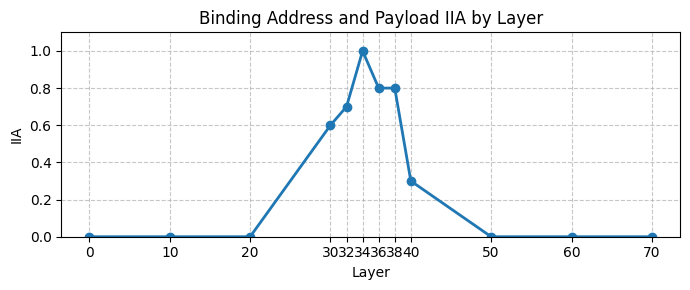

In [8]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_binding_addr_and_payload.keys())
accuracies = list(accs_binding_addr_and_payload.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Binding Address and Payload IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Source (Fig. 6 and Fig. 13 in the paper)

In [9]:
n_samples = 10
batch_size = 1

dataset = get_reversed_sent_diff_state_counterfacts(
    all_characters, all_objects, all_states, n_samples
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [10]:
idx = 0
print("COUNTERFACTUAL EXAMPLE")
print("=" * 25)
print(dataset[idx]["counterfactual_prompt"], dataset[idx]["counterfactual_ans"])
print()

print("CLEAN EXAMPLE")
print("=" * 25)
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

COUNTERFACTUAL EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Diane and Fred are working in a busy restaurant. To complete an order, Diane grabs an opaque horn and fills it with float. Then Fred grabs another opaque flute and fills it with soda.
Question: What does Diane believe the horn contains?
Answer: float

CLEAN EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A charac

In [11]:
_, errors = error_detection(model, dataloader, is_remote)
print(
    f"Dataset size to be used for IIA: {len(dataset) - len(errors)} ({len(errors)} errors)"
)

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

Dataset size to be used for IIA: 10 (0 errors)


## Freezing the address and payload of Binding lookback (Fig.6 in the paper)

In [12]:
accs_source_1 = {}
patch_layers = (
    [i for i in range(0, 20, 10)]
    + [i for i in range(20, 42, 2)]
    + [i for i in range(50, model.config.num_hidden_layers, 10)]
)

for layer_idx in tqdm(patch_layers):
    correct, total = 0, 0

    for bi, batch in enumerate(dataloader):
        counterfactual_prompt = batch["counterfactual_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        charac_indices = [131, 133, 146, 147, 158, 159]
        object_indices = [150, 151, 162, 163]
        state_indices = [155, 156, 167, 168]
        reversed_charac_indices = [133, 131, 158, 159, 146, 147]
        reversed_obj_indices = [162, 163, 150, 151]
        reversed_state_indices = [167, 168, 155, 156]
        n_layers = model.config.num_hidden_layers
        counterfactual_layer_out, clean_layer_out = (
            defaultdict(dict),
            defaultdict(dict),
        )
        with torch.no_grad():
            with model.trace(counterfactual_prompt, remote=is_remote):
                for l in range(layer_idx + 1):
                    for i, token_idx in enumerate(charac_indices + object_indices):
                        counterfactual_layer_out[l][i] = (
                            model.model.layers[l].output[0, token_idx].save()
                        )

            with model.trace(clean_prompt, remote=is_remote):
                for l in range(n_layers):
                    for i, token_idx in enumerate(state_indices):
                        clean_layer_out[l][i] = (
                            model.model.layers[l].output[0, token_idx].save()
                        )

            with model.trace(clean_prompt, remote=is_remote):
                for l in range(layer_idx + 1):
                    for i, token_idx in enumerate(
                        reversed_charac_indices + reversed_obj_indices
                    ):
                        model.model.layers[l].output[0, token_idx] = (
                            counterfactual_layer_out[l][i]
                        )

                for l in range(n_layers):
                    for i, token_idx in enumerate(state_indices):
                        model.model.layers[l].output[0, token_idx] = clean_layer_out[l][
                            i
                        ]

                pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del counterfactual_layer_out, clean_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_source_1[layer_idx] = acc

  6%|▋         | 1/16 [00:06<01:41,  6.76s/it]

Layer: 0 | Accuracy: 0.0


 12%|█▎        | 2/16 [00:13<01:37,  6.94s/it]

Layer: 10 | Accuracy: 0.0


 19%|█▉        | 3/16 [00:20<01:31,  7.04s/it]

Layer: 20 | Accuracy: 0.8


 25%|██▌       | 4/16 [00:28<01:25,  7.09s/it]

Layer: 22 | Accuracy: 0.8


 31%|███▏      | 5/16 [00:35<01:19,  7.20s/it]

Layer: 24 | Accuracy: 1.0


 38%|███▊      | 6/16 [00:42<01:12,  7.22s/it]

Layer: 26 | Accuracy: 1.0


 44%|████▍     | 7/16 [00:50<01:05,  7.25s/it]

Layer: 28 | Accuracy: 1.0


 50%|█████     | 8/16 [00:57<00:58,  7.28s/it]

Layer: 30 | Accuracy: 1.0


 56%|█████▋    | 9/16 [01:04<00:51,  7.34s/it]

Layer: 32 | Accuracy: 1.0


 62%|██████▎   | 10/16 [01:12<00:44,  7.36s/it]

Layer: 34 | Accuracy: 1.0


 69%|██████▉   | 11/16 [01:19<00:36,  7.38s/it]

Layer: 36 | Accuracy: 0.6


 75%|███████▌  | 12/16 [01:27<00:29,  7.44s/it]

Layer: 38 | Accuracy: 0.5


 81%|████████▏ | 13/16 [01:34<00:22,  7.47s/it]

Layer: 40 | Accuracy: 0.2


 88%|████████▊ | 14/16 [01:42<00:15,  7.57s/it]

Layer: 50 | Accuracy: 0.2


 94%|█████████▍| 15/16 [01:50<00:07,  7.65s/it]

Layer: 60 | Accuracy: 0.2


100%|██████████| 16/16 [01:58<00:00,  7.42s/it]

Layer: 70 | Accuracy: 0.2


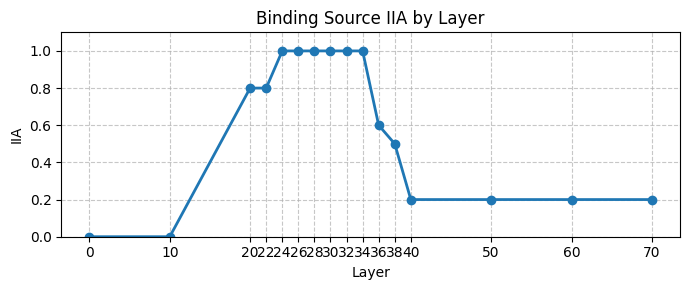

In [13]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_source_1.keys())
accuracies = list(accs_source_1.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Binding Source IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Without freezing the address and payload of Binding lookback (Fig.12 in the paper)

In [15]:
accs_source_2 = {}
patch_layers = (
    [i for i in range(0, 20, 10)]
    + [i for i in range(20, 42, 2)]
    + [i for i in range(50, model.config.num_hidden_layers, 10)]
)

for layer_idx in tqdm(patch_layers):
    correct, total = 0, 0

    for bi, batch in enumerate(dataloader):
        counterfactual_prompt = batch["counterfactual_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        charac_indices = [131, 133, 146, 147, 158, 159]
        object_indices = [150, 151, 162, 163]
        state_indices = [155, 156, 167, 168]
        reversed_charac_indices = [133, 131, 158, 159, 146, 147]
        reversed_obj_indices = [162, 163, 150, 151]
        reversed_state_indices = [167, 168, 155, 156]
        n_layers = model.config.num_hidden_layers
        counterfactual_layer_out, clean_layer_out = (
            defaultdict(dict),
            defaultdict(dict),
        )
        with torch.no_grad():
            with model.trace(remote=is_remote) as tracer:
                with tracer.invoke(counterfactual_prompt):
                    for l in range(layer_idx + 1):
                        for i, token_idx in enumerate(charac_indices + object_indices):
                            counterfactual_layer_out[l][i] = model.model.layers[
                                l
                            ].output[0, token_idx].save()

                with tracer.invoke(clean_prompt):
                    for l in range(layer_idx + 1):
                        for i, token_idx in enumerate(
                            reversed_charac_indices + reversed_obj_indices
                        ):
                            model.model.layers[l].output[0, token_idx] = (
                                counterfactual_layer_out[l][i]
                            )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del counterfactual_layer_out, clean_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_source_2[layer_idx] = acc

  6%|▋         | 1/16 [00:03<00:51,  3.45s/it]

Layer: 0 | Accuracy: 0.0


 12%|█▎        | 2/16 [00:07<00:50,  3.61s/it]

Layer: 10 | Accuracy: 0.0


 19%|█▉        | 3/16 [00:11<00:49,  3.77s/it]

Layer: 20 | Accuracy: 0.0


 25%|██▌       | 4/16 [00:15<00:46,  3.86s/it]

Layer: 22 | Accuracy: 0.0


 31%|███▏      | 5/16 [00:19<00:44,  4.01s/it]

Layer: 24 | Accuracy: 0.0


 38%|███▊      | 6/16 [00:23<00:40,  4.04s/it]

Layer: 26 | Accuracy: 0.0


 44%|████▍     | 7/16 [00:27<00:37,  4.14s/it]

Layer: 28 | Accuracy: 0.0


 50%|█████     | 8/16 [00:32<00:33,  4.16s/it]

Layer: 30 | Accuracy: 0.0


 56%|█████▋    | 9/16 [00:36<00:29,  4.24s/it]

Layer: 32 | Accuracy: 0.2


 62%|██████▎   | 10/16 [00:40<00:25,  4.27s/it]

Layer: 34 | Accuracy: 0.2


 69%|██████▉   | 11/16 [00:45<00:21,  4.34s/it]

Layer: 36 | Accuracy: 0.2


 75%|███████▌  | 12/16 [00:49<00:17,  4.37s/it]

Layer: 38 | Accuracy: 0.2


 81%|████████▏ | 13/16 [00:54<00:13,  4.44s/it]

Layer: 40 | Accuracy: 0.2


 88%|████████▊ | 14/16 [00:59<00:09,  4.58s/it]

Layer: 50 | Accuracy: 0.2


 94%|█████████▍| 15/16 [01:04<00:04,  4.74s/it]

Layer: 60 | Accuracy: 0.2


100%|██████████| 16/16 [01:09<00:00,  4.36s/it]

Layer: 70 | Accuracy: 0.2


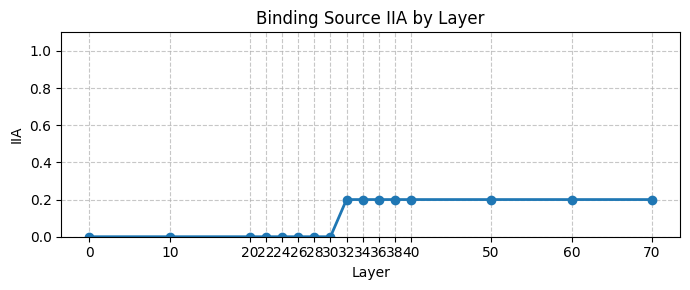

In [16]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_source_2.keys())
accuracies = list(accs_source_2.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Binding Source IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Pointer (Query Character OI; Fig. 16 in the paper)

In [17]:
n_samples = 10
batch_size = 1

dataset = get_query_charac_oi(all_characters, all_objects, all_states, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [18]:
idx = 0
print("COUNTERFACTUAL EXAMPLE")
print("=" * 25)
print(dataset[idx]["counterfactual_prompt"], dataset[idx]["counterfactual_ans"])
print()

print("CLEAN EXAMPLE")
print("=" * 25)
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

COUNTERFACTUAL EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Greg and Kevin are working in a busy restaurant. To complete an order, Greg grabs an opaque urn and fills it with stout. Then Kevin grabs another opaque can and fills it with monster.
Question: What does Greg believe the urn contains?
Answer: stout

CLEAN EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A characte

In [19]:
_, errors = error_detection(model, dataloader, is_remote)
print(
    f"Dataset size to be used for IIA: {len(dataset) - len(errors)} ({len(errors)} errors)"
)

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

Dataset size to be used for IIA: 10 (0 errors)


In [20]:
accs_query_charac_oi = {}
patch_layers = (
    [i for i in range(0, 20, 10)]
    + [i for i in range(16, 38, 2)]
    + [i for i in range(40, model.config.num_hidden_layers, 10)]
)

for layer_idx in tqdm(patch_layers, total=len(patch_layers)):
    correct, total = 0, 0
    for bi, batch in enumerate(dataloader):
        if bi in errors:
            continue
        counterfactual_prompt = batch["counterfactual_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        counterfactual_layer_out, clean_state_out = defaultdict(dict), defaultdict(dict)
        with torch.no_grad():
            with model.trace(remote=is_remote) as tracer:
                with tracer.invoke(counterfactual_prompt):
                    for token_idx in [-8, -7]:
                        counterfactual_layer_out[token_idx] = model.model.layers[
                            layer_idx
                        ].output[0, token_idx].save()

                with tracer.invoke(clean_prompt):
                    for token_idx in [-8, -7]:
                        model.model.layers[layer_idx].output[0, token_idx] = (
                            counterfactual_layer_out[token_idx]
                        )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        # print(f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}")
        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del counterfactual_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_query_charac_oi[layer_idx] = acc

  6%|▌         | 1/17 [00:03<00:54,  3.44s/it]

Layer: 0 | Accuracy: 0.0


 12%|█▏        | 2/17 [00:06<00:51,  3.44s/it]

Layer: 10 | Accuracy: 0.0


 18%|█▊        | 3/17 [00:10<00:48,  3.44s/it]

Layer: 16 | Accuracy: 1.0


 24%|██▎       | 4/17 [00:13<00:44,  3.44s/it]

Layer: 18 | Accuracy: 1.0


 29%|██▉       | 5/17 [00:17<00:41,  3.44s/it]

Layer: 20 | Accuracy: 1.0


 35%|███▌      | 6/17 [00:20<00:37,  3.44s/it]

Layer: 22 | Accuracy: 1.0


 41%|████      | 7/17 [00:24<00:34,  3.44s/it]

Layer: 24 | Accuracy: 1.0


 47%|████▋     | 8/17 [00:27<00:30,  3.44s/it]

Layer: 26 | Accuracy: 1.0


 53%|█████▎    | 9/17 [00:30<00:27,  3.44s/it]

Layer: 28 | Accuracy: 1.0


 59%|█████▉    | 10/17 [00:34<00:24,  3.44s/it]

Layer: 30 | Accuracy: 0.8


 65%|██████▍   | 11/17 [00:37<00:20,  3.44s/it]

Layer: 32 | Accuracy: 0.4


 71%|███████   | 12/17 [00:41<00:17,  3.44s/it]

Layer: 34 | Accuracy: 0.0


 76%|███████▋  | 13/17 [00:44<00:13,  3.44s/it]

Layer: 36 | Accuracy: 0.0


 82%|████████▏ | 14/17 [00:48<00:10,  3.44s/it]

Layer: 40 | Accuracy: 0.0


 88%|████████▊ | 15/17 [00:51<00:06,  3.44s/it]

Layer: 50 | Accuracy: 0.0


 94%|█████████▍| 16/17 [00:54<00:03,  3.44s/it]

Layer: 60 | Accuracy: 0.0


100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

Layer: 70 | Accuracy: 0.0


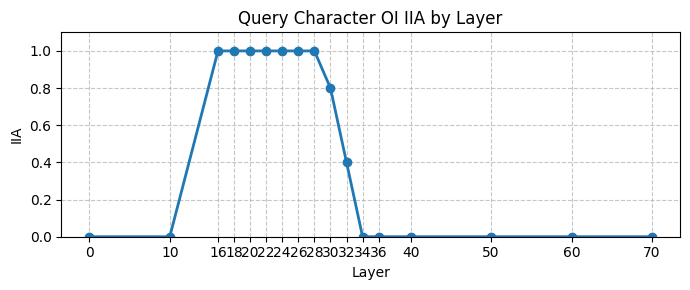

In [21]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_query_charac_oi.keys())
accuracies = list(accs_query_charac_oi.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Query Character OI IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Pointer (Query Object OI; Fig. 17 in the paper)

In [22]:
n_samples = 10
batch_size = 1

dataset = get_query_object_oi(all_characters, all_objects, all_states, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [23]:
idx = 0
print("COUNTERFACTUAL EXAMPLE")
print("=" * 25)
print(dataset[idx]["counterfactual_prompt"], dataset[idx]["counterfactual_ans"])
print()

print("CLEAN EXAMPLE")
print("=" * 25)
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

COUNTERFACTUAL EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Heidi and Jack are working in a busy restaurant. To complete an order, Heidi grabs an opaque mug and fills it with cocktail. Then Jack grabs another opaque dispenser and fills it with punch.
Question: What does Heidi believe the mug contains?
Answer: cocktail

CLEAN EXAMPLE
Instruction: 1. Track the belief of each character as described in the story. 2.

In [24]:
_, errors = error_detection(model, dataloader, is_remote)
print(
    f"Dataset size to be used for IIA: {len(dataset) - len(errors)} ({len(errors)} errors)"
)

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

Dataset size to be used for IIA: 9 (1 errors)


In [25]:
accs_query_object_oi = {}
patch_layers = (
    [i for i in range(0, 20, 10)]
    + [i for i in range(16, 38, 2)]
    + [i for i in range(40, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        counterfactual_prompt = batch["counterfactual_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        counterfactual_layer_out, clean_state_out = defaultdict(dict), defaultdict(dict)
        with torch.no_grad():
            with model.trace(remote=is_remote) as tracer:
                with tracer.invoke(counterfactual_prompt):
                    for token_idx in [-5, -4]:
                        counterfactual_layer_out[token_idx] = model.model.layers[
                            layer_idx
                        ].output[0, token_idx].save()

                with tracer.invoke(clean_prompt):
                    for token_idx in [-5, -4]:
                        model.model.layers[layer_idx].output[0, token_idx] = (
                            counterfactual_layer_out[token_idx]
                        )

                    pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        # print(f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}")
        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del counterfactual_layer_out, pred
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_query_object_oi[layer_idx] = acc

100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 16 | Accuracy: 0.89


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 18 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 20 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Layer: 22 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 24 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 26 | Accuracy: 1.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 28 | Accuracy: 0.89


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 30 | Accuracy: 0.44


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 32 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 34 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 36 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 40 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 50 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Layer: 60 | Accuracy: 0.0


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

Layer: 70 | Accuracy: 0.0


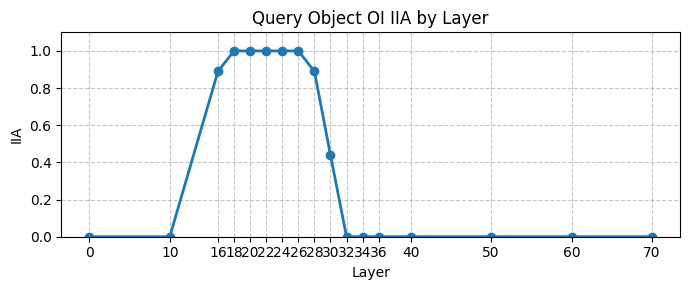

In [26]:
# Visualize accs_binding_addr_and_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_query_object_oi.keys())
accuracies = list(accs_query_object_oi.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Query Object OI IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()